In [1]:
# 以沪深300数据集为例，构建特征和目标值，拟合特征与目标值，并评估模型
# 数据已经经过了初步清洗，剔除掉每天的涨跌停股和ST股，并使用后复权价格
# 如果不做回测，可以注释掉一切带"_test"的行

import pandas as pd
from scutquant import scutquant, alpha

In [2]:
# 读取数据
df_train = pd.read_csv('D:/Desktop/CSI300.csv')
df_test = pd.read_csv('D:/Desktop/CSI300_test.csv')
df_train.set_index(['datetime', 'instrument'], inplace=True)
df_test.set_index(['datetime', 'instrument'], inplace=True)

df = pd.concat([df_train, df_test], axis=0)

#sup_data = pd.read_csv('D:/Desktop/SH000300.csv')  # supplemental_data
#df = scutquant.join_data(df, sup_data, time='datetime', col=['idx_close'], index=['datetime', 'instrument'])

df

open       close        high         low  \
datetime   instrument                                                   
2010-01-04 300003.SZ    51.590000   51.500000   51.850000   51.100000   
           300014.SZ    39.700000   39.470000   39.900000   39.240000   
           300015.SZ    48.970000   48.770000   49.190000   48.550000   
           300033.SZ    72.010000   74.570000   76.060000   71.610000   
           600000.SH    64.829142   62.928517   64.947931   62.839425   
...                           ...         ...         ...         ...   
2022-12-23 688363.SH   130.338644  130.842543  133.513211  129.078895   
           688396.SH    53.248294   52.735905   54.052042   52.344078   
           688561.SH    61.590000   67.160000   68.190000   61.590000   
           688599.SH    55.856185   54.938671   56.263968   53.909017   
           688981.SH    40.900000   41.060000   41.330000   40.830000   

                           volume        amount  
datetime   instrument                            
2010-01-04 300003.SZ     842437.0  4.328901e+07  
           300014.SZ     727706.0  2.873182e+07  
           300015.SZ     740314.0  3.613862e+07  
           300033.SZ    3627417.0  2.702477e+08  
           600000.SH   66191338.0  1.419984e+09  
...                           ...           ...  
2022-12-23 688363.SH    2334792.0  3.036193e+08  
           688396.SH    3462319.0  1.820840e+08  
           688561.SH    3554834.0  2.353862e+08  
           688599.SH   10072858.0  5.395502e+08  
           688981.SH    7428877.0  3.055459e+08  

[651282 rows x 6 columns]

In [3]:
# 清洗数据(由于原始数据已经经过了初步清洗，所以以下步骤可以省去)

# 查看缺失值和数据类型
df.info()
# 查看是否存在异常数据
#df.describe()
# 处理缺失值
#df.dropna(axis=1, how='all', inplace=True)  # 去除掉全为缺失值的列
#df = df.groupby(['instrument']).fillna(method='ffill').dropna()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 651282 entries, ('2010-01-04', '300003.SZ') to ('2022-12-23', '688981.SH')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    651282 non-null  float64
 1   close   651282 non-null  float64
 2   high    651282 non-null  float64
 3   low     651282 non-null  float64
 4   volume  651282 non-null  float64
 5   amount  651282 non-null  float64
dtypes: float64(6)
memory usage: 32.4+ MB


In [4]:
# 下面开始构造目标值和特征

df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

feature_kwargs = {
    'data': df,
    'price': 'close',
    'label': 'label',
    'open': 'open',
    'volume': 'volume',
    'amount': 'amount',
    'high': 'high',
    'low': 'low',
    'shift': 2,
    'groupby': 'instrument'
}
features = alpha.make_factors(feature_kwargs, windows=[5, 10, 20, 30, 60])
X = pd.concat([features, df['label']], axis=1)

# 伪市场因子,需要读取supplemental data
# df['idx_ret'] = scutquant.price2ret(df['idx_close'], shift1=1, shift2=0, groupby='instrument')
#X['market'] = df['idx_ret'] / df['close']
X.describe()

,label0,label1,label2,label3,label4,ma5,std5,max5,min5,beta5,...,rsv30,ksft230,rsv60,ksft260,klen5,klen10,klen20,klen30,klen60,label
count,650662.000000,650352.000000,650042.000000,649732.000000,649422.000000,649422.000000,649422.000000,649422.000000,649422.000000,649112.000000,...,642292.000000,642292.000000,632992.000000,632992.000000,650042.000000,648492.000000,645392.000000,642292.000000,632992.000000,650662.000000
mean,0.001135,0.001137,0.001138,0.001139,0.001146,0.001139,0.027136,0.036448,-0.031185,0.000004,...,12.845541,-0.004183,12.657972,-0.003187,0.034986,0.034986,0.035005,0.035034,0.035124,0.001135
std,0.040568,0.040576,0.040582,0.040591,0.040598,0.016968,0.031020,0.061755,0.033825,0.011590,...,72.850301,0.116506,71.642050,0.088359,0.016861,0.015727,0.014814,0.014334,0.013537,0.040568
min,-0.800138,-0.800138,-0.800138,-0.800138,-0.800138,-0.173861,0.000000,-0.079832,-0.800138,-1.000408,...,-0.999736,-0.520755,-0.999725,-0.430303,0.001666,0.003968,0.005229,0.005450,0.005886,-0.800138
25%,-0.012942,-0.012945,-0.012945,-0.012946,-0.012939,-0.005933,0.013124,0.012513,-0.038443,-0.004065,...,-0.817311,-0.082727,-0.819934,-0.062880,0.022901,0.023718,0.024393,0.024754,0.025437,-0.012942
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000216,0.020510,0.024430,-0.022871,-0.000004,...,-0.099214,-0.004794,-0.114001,-0.004256,0.032174,0.032700,0.033067,0.033275,0.033691,0.000000
75%,0.012839,0.012844,0.012846,0.012852,0.012862,0.006940,0.032053,0.043512,-0.012720,0.004013,...,4.100062,0.073292,4.023037,0.054974,0.043721,0.043438,0.043270,0.043163,0.042993,0.012839
max,5.026166,5.026166,5.026166,5.026166,5.026166,1.012244,2.259588,5.026166,0.077165,0.992330,...,6708.836760,0.554738,6820.357592,0.467794,0.184640,0.158079,0.138242,0.124034,0.110373,5.026166


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580608 entries, ('2010-01-04', '300003.SZ') to ('2021-12-31', '688981.SH')
Columns: 146 entries, label0 to label
dtypes: float64(146)
memory usage: 649.1+ MB
None
X_mis= 0.9314373897707231
clean dataset done 

pop label done 

label norm done 



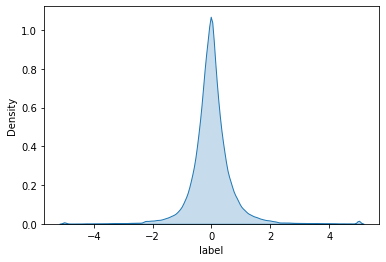

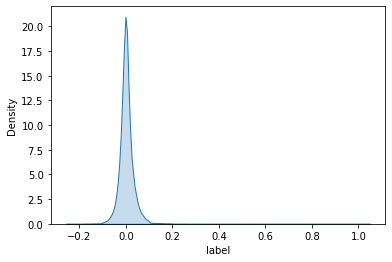

norm data done 

all works done 



In [5]:
# 先拆分出测试集，然后做特征工程、数据清洗，并根据mutual information score选择特征

X_test = X[X.index.isin(df_test.index)]
X = X[~X.index.isin(df_test.index)]

# 使用auto_process()自动处理训练集和验证集(将在以后的版本完善拆分数据集的函数，使其能够同时处理训练、验证和测试集)
# select需要消耗大量时间，但可以过滤掉噪声。使用时需要在时间开销和模型性能之间权衡
x_train, x_valid, y_train, y_valid, ymean, ystd = scutquant.auto_process(X, 'label', groupby='instrument', select=False)

In [6]:
# 手动处理测试集
X_test = X_test.groupby(['instrument']).fillna(method='ffill').dropna()
x_test = X_test.copy()
y_test = x_test.pop('label')
col = x_train.columns
x_test = x_test[col]
x_test = scutquant.zscorenorm(x_test)

In [7]:
x_train.head(5)

label0    label1    label2    label3    label4  \
datetime   instrument                                                     
2010-04-08 600009.SH   0.055619 -0.283412 -0.005737  0.189235  0.055327   
           600010.SH  -0.485455  0.540235  0.126517  0.502992  0.076851   
           600015.SH  -0.669581 -0.396540  0.469332 -0.171532 -0.065546   
           600016.SH  -0.385023 -0.321622  0.028562 -0.000739  0.146467   
           600018.SH  -0.312997 -0.150381 -0.029889  0.131537  0.050802   

                            ma5      std5      max5      min5     beta5  ...  \
datetime   instrument                                                    ...   
2010-04-08 600009.SH  -2.169950  2.174420  0.958796 -4.133845 -0.271194  ...   
           600010.SH   0.264895  1.085392  0.958796 -0.611643  0.169181  ...   
           600015.SH  -0.508541  1.708189  1.143962 -1.903845  0.496039  ...   
           600016.SH   0.824679  1.888004  1.143962 -1.903845  0.023929  ...   
           600018.SH   1.930619  1.617521  1.143962 -1.903845  0.056739  ...   

                        ksft220     rsv30   ksft230     rsv60   ksft260  \
datetime   instrument                                                     
2010-04-08 600009.SH  -0.668408 -0.186068 -0.362130 -0.184674 -0.744143   
           600010.SH  -0.962352 -0.190827 -0.386843 -0.189474 -0.614075   
           600015.SH  -1.177010 -0.189861 -0.733490 -0.188500 -0.755837   
           600016.SH  -0.984685 -0.182198 -0.633490 -0.180793 -0.634289   
           600018.SH  -1.075361 -0.183242 -0.505138 -0.182013 -0.572338   

                          klen5    klen10    klen20    klen30    klen60  
datetime   instrument                                                    
2010-04-08 600009.SH   5.000000  3.752708  2.199810  1.834966  1.666414  
           600010.SH   5.000000  4.153007  2.202049  2.022593  1.745299  
           600015.SH   4.939991  4.364991  2.655119  2.233508  1.820953  
           600016.SH   4.799843  4.778867  2.871260  2.361969  1.875025  
           600018.SH   3.710124  4.847178  2.933574  2.442729  1.921177  

[5 rows x 145 columns]

In [8]:
# 拟合模型

xgb_params = {
    'est': 800,
    'eta': 0.0421,
    'colsamp': 0.9325,
    'subsamp': 0.8789,
    'max_depth': 10,
    'l1': 205.6999,
    'l2': 580.9768,
    'early_stopping_rounds': 25
}
model = scutquant.hybrid(lrg_method='ridge', xgb_params=xgb_params, weight=[0.4, 0.6])
model.fit(x_train, y_train, x_valid, (y_valid-ymean)/ystd)

pred = model.predict(x_test)
pred = pd.DataFrame({'predict': pred}, index=x_test.index)
pred += ymean
pred *= ystd

[0]	validation_0-rmse:0.83835
[1]	validation_0-rmse:0.82701
[2]	validation_0-rmse:0.81660
[3]	validation_0-rmse:0.80697
[4]	validation_0-rmse:0.79788
[5]	validation_0-rmse:0.78952
[6]	validation_0-rmse:0.78181
[7]	validation_0-rmse:0.77452
[8]	validation_0-rmse:0.76790
[9]	validation_0-rmse:0.76189
[10]	validation_0-rmse:0.75626
[11]	validation_0-rmse:0.75091
[12]	validation_0-rmse:0.74610
[13]	validation_0-rmse:0.74170
[14]	validation_0-rmse:0.73762
[15]	validation_0-rmse:0.73380
[16]	validation_0-rmse:0.73037
[17]	validation_0-rmse:0.72717
[18]	validation_0-rmse:0.72439
[19]	validation_0-rmse:0.72163
[20]	validation_0-rmse:0.71909
[21]	validation_0-rmse:0.71687
[22]	validation_0-rmse:0.71482
[23]	validation_0-rmse:0.71291
[24]	validation_0-rmse:0.71110
[25]	validation_0-rmse:0.70951
[26]	validation_0-rmse:0.70806
[27]	validation_0-rmse:0.70674
[28]	validation_0-rmse:0.70558
[29]	validation_0-rmse:0.70441
[30]	validation_0-rmse:0.70328
[31]	validation_0-rmse:0.70238
[32]	validation_0-

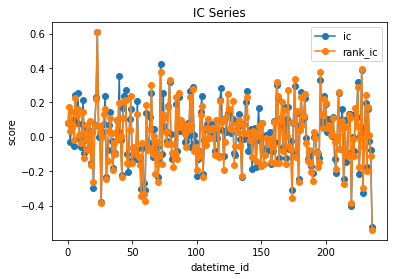

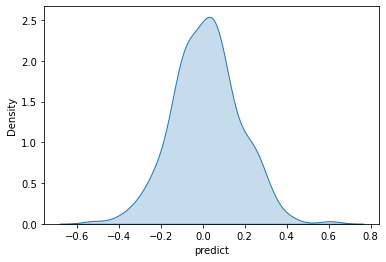

ic= 0.0152596197586087 icir= 0.0956518804941482 rank_ic= 0.009036299358758312 rank_icir= 0.055727445481490376


In [9]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

In [10]:
# 使用pearson相关系数评判拟合优度
r = scutquant.pearson_corr(pred.values, y_test)
r[0]

0.050850742813884894

In [11]:
# 以下为回测部分
from scutquant import executor

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df, time='datetime', price='close')

# 无底仓时只用设置cash，剩余的会自动设置
acc={
    'cash': 1000000000,
    'position': None,
    'available': None,
    'ben_position': None,
}
exe = executor.Executor(generator={'mode': 'generate'}, acc=acc, cost_buy=0.0015, cost_sell=0.0005, min_cost=5, risk_degree=0.95, 
                        auto_offset=True, offset_freq=2, buy_only=True)
exe.execute(data=pred, verbose=0)

E(r): -0.06258242791851763
std: 0.02287229822790171
E(r_benchmark): -0.13770665127800302
std_benchmark: 0.05320053573200636 

Cumulative Rate of Return: -0.08233517487155328
Cumulative Rate of Return(benchmark): -0.19375655308159512
Cumulative Excess Rate of Return: 0.11142137821004183 

Max Drawdown: -0.10839110894794046
Max Drawdown(benchmark): -0.23812980368328573 

Sharpe Ratio: -2.7397605205626228
Information Ratio: 3.2845069879266453


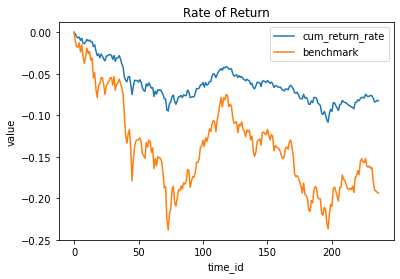

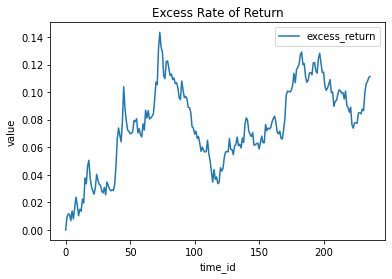

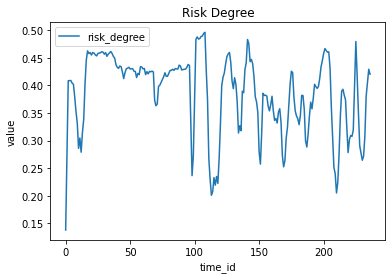

In [12]:
# 报告回测结果
# 对比2022年主动管理型基金的业绩，这表现算是在平均线以上
from scutquant import report

user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365)  # 无风险收益率默认为年化3%，可以通过参数rf调节

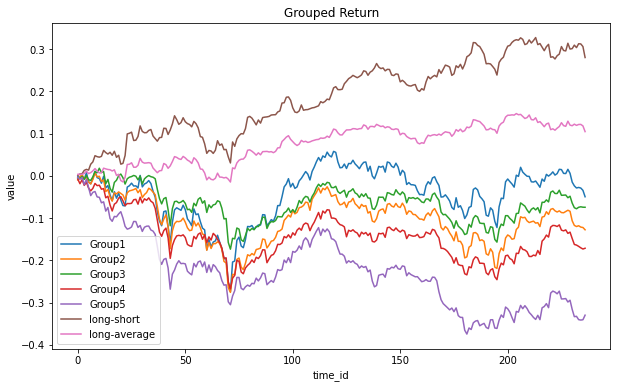

In [13]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)